In [1]:
import torch

from VGG_BatchNorm.models.vgg import VGG_A_Dropout

# 判断是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"当前使用的设备是: {device}")

当前使用的设备是: cuda


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

from torch import nn
import numpy as np
import torch
import os
import random
from tqdm import tqdm as tqdm
from IPython import display

from models.vgg import VGG_A
from models.vgg import VGG_BatchNorm # you need to implement this network
from data.loaders import get_cifar_loader
from models.vgg import VGG_A_Dropout

# ## Constants (parameters) initialization
device_id = [0]
num_workers = 0
batch_size = 128

# add our package dir to path 
module_path = os.path.dirname(os.getcwd())
home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

# Make sure you are using the right device.
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
device = torch.device("cuda:0".format(3) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
def unnormalize(img, mean, std):
    """Unnormalize a tensor image."""
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

Image batch shape: torch.Size([128, 3, 32, 32])
Label batch shape: torch.Size([128])
First 10 labels: [9, 6, 6, 6, 8, 8, 6, 4, 1, 6]


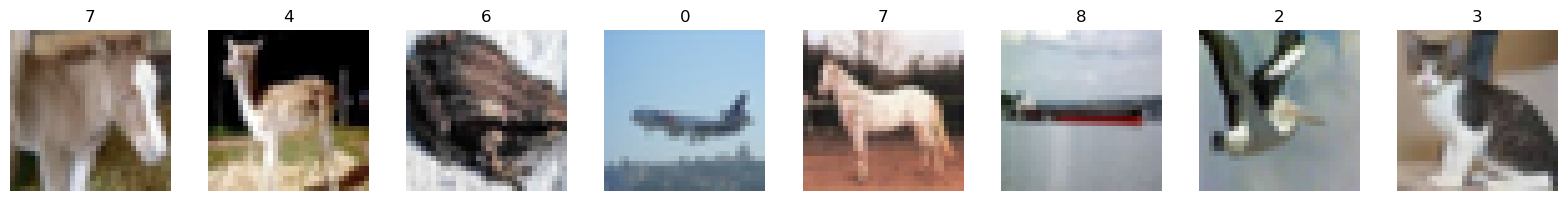

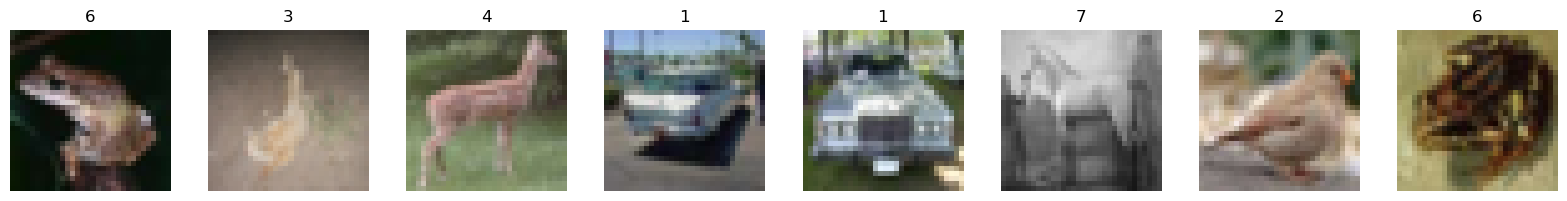

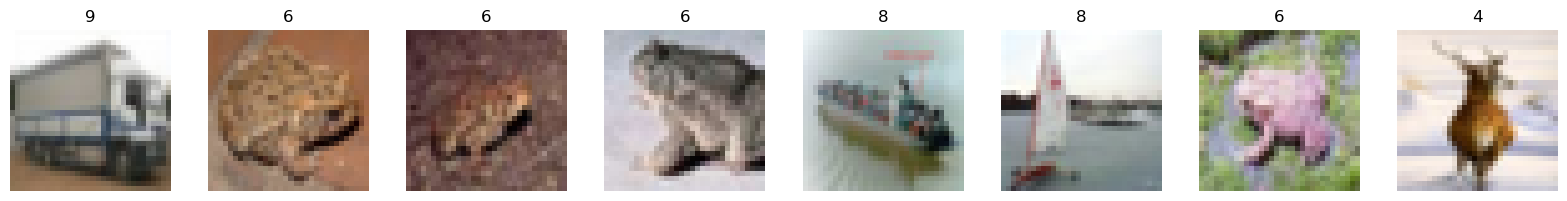

In [7]:
# Initialize your data loader and
# make sure that dataloader works
# as expected by observing one
# sample from it.
train_loader = get_cifar_loader(train=True)
val_loader = get_cifar_loader(train=False)
for X, y in train_loader:
    print(f"Image batch shape: {X.shape}")   # e.g., torch.Size([128, 3, 32, 32])
    print(f"Label batch shape: {y.shape}")   # e.g., torch.Size([128])
    print(f"First 10 labels: {y[:10].tolist()}")

    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    
    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        img = unnormalize(X[i].clone(), mean, std)  # 反标准化，不影响原数据
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{y[i].item()}")
    
    plt.tight_layout()
    plt.show()
    break

In [8]:
print(len(train_loader)*128,len(train_loader))

50048 391


In [9]:
print(len(val_loader)*128)

10112


In [10]:
# This function is used to calculate the accuracy of model classification
def get_accuracy(data_loader):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [11]:
# Set a random seed to ensure reproducible results
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [15]:

# We use this function to complete the entire
# training process. In order to plot the loss landscape,
# you need to record the loss value of each step.
# Of course, as before, you can test your model
# after drawing a training round and save the curve
# to observe the training
def train(model, optimizer, criterion, train_loader, val_loader, scheduler=None, epochs_n=100, best_model_path=None):
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
   

    batches_n = len(train_loader)
    losses_list = []
    grads = []
    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:
            scheduler.step()
        model.train()

        loss_list = []  # use this to record the loss value of each step
        grad = []  # use this to record the loss gradient of each step
        learning_curve[epoch] = 0  # maintain this to plot the training curve

        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            # You may need to record some variable values here
            # if you want to get loss gradient, use
            # grad = model.classifier[4].weight.grad.clone()
            ## --------------------
            # Add your code
            loss_value = loss.item()
            loss_list.append(loss_value)
            learning_curve[epoch] += loss_value
            
            loss.backward()
            
            grad_current = model.classifier[4].weight.grad.clone().cpu().numpy()
            grad.append(grad_current)
            ## -------------------
            
            optimizer.step()

        losses_list.append(loss_list)
        grads.append(grad)
        

        learning_curve[epoch] /= batches_n
        
       
     
        
        train_accuracy = get_accuracy(train_loader)
        val_accuracy = get_accuracy(val_loader)
        
        # 更新曲线数据
        train_accuracy_curve[epoch] = train_accuracy
        val_accuracy_curve[epoch] = val_accuracy
        
        
        # 更新最佳模型
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            if best_model_path is not None:
                torch.save(model.state_dict(), best_model_path)
        
        
        print(f'Epoch {epoch+1}/{epochs_n} - '
              f'Train Loss: {learning_curve[epoch]:.4f} | '
              f'Train Acc: {train_accuracy:.4f} | '
              f'Val Acc: {val_accuracy:.4f} | '
              f'Best Val Acc: {max_val_accuracy:.4f} ')
        
        # display.clear_output(wait=True)
        # f, axes = plt.subplots(1, 2, figsize=(15, 3))
        # axes[0].plot(learning_curve)
        # 
        # # Test your model and save figure here (not required)
        # # remember to use model.eval()
        # ## --------------------
        # # Add code as needed
        # axes[0].plot(learning_curve)
        # axes[0].set_title('Training Loss')
        # axes[0].set_xlabel('Epoch')
        # axes[0].set_ylabel('Loss')
        # 
        # # 绘制准确率曲线
        # axes[1].plot(train_accuracy_curve, label='Train')
        # axes[1].plot(val_accuracy_curve, label='Validation')
        # axes[1].set_title('Accuracy')
        # axes[1].set_xlabel('Epoch')
        # axes[1].set_ylabel('Accuracy')
        # axes[1].legend()
        # 
        # plt.show()
        ## --------------------

    return learning_curve, train_accuracy_curve, val_accuracy_curve, losses_list, grads


In [16]:
epo = 20


set_random_seeds(seed_value=2020, device=device)
model = VGG_A_Dropout()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
learning_curve, train_accuracy_curve, val_accuracy_curve, loss, grads = train(model, optimizer, criterion, train_loader, val_loader, epochs_n=epo,best_model_path='best_model_vgg_dropout.pth')


  5%|▌         | 1/20 [01:15<24:03, 75.98s/epoch]

Epoch 1/20 - Train Loss: 1.8591 | Train Acc: 0.4182 | Val Acc: 0.4108 | Best Val Acc: 0.4108 


 10%|█         | 2/20 [02:30<22:34, 75.25s/epoch]

Epoch 2/20 - Train Loss: 1.4095 | Train Acc: 0.5500 | Val Acc: 0.5323 | Best Val Acc: 0.5323 


 15%|█▌        | 3/20 [03:45<21:16, 75.06s/epoch]

Epoch 3/20 - Train Loss: 1.1415 | Train Acc: 0.6618 | Val Acc: 0.6298 | Best Val Acc: 0.6298 


 20%|██        | 4/20 [04:59<19:55, 74.71s/epoch]

Epoch 4/20 - Train Loss: 0.9589 | Train Acc: 0.7217 | Val Acc: 0.6758 | Best Val Acc: 0.6758 


 25%|██▌       | 5/20 [06:14<18:42, 74.82s/epoch]

Epoch 5/20 - Train Loss: 0.8175 | Train Acc: 0.7531 | Val Acc: 0.6904 | Best Val Acc: 0.6904 


 30%|███       | 6/20 [07:28<17:24, 74.57s/epoch]

Epoch 6/20 - Train Loss: 0.7092 | Train Acc: 0.7915 | Val Acc: 0.7035 | Best Val Acc: 0.7035 


 35%|███▌      | 7/20 [08:42<16:07, 74.39s/epoch]

Epoch 7/20 - Train Loss: 0.6219 | Train Acc: 0.8343 | Val Acc: 0.7261 | Best Val Acc: 0.7261 


 40%|████      | 8/20 [09:57<14:54, 74.51s/epoch]

Epoch 8/20 - Train Loss: 0.5347 | Train Acc: 0.8655 | Val Acc: 0.7352 | Best Val Acc: 0.7352 


 45%|████▌     | 9/20 [11:15<13:50, 75.47s/epoch]

Epoch 9/20 - Train Loss: 0.4731 | Train Acc: 0.8850 | Val Acc: 0.7365 | Best Val Acc: 0.7365 


 50%|█████     | 10/20 [12:29<12:31, 75.12s/epoch]

Epoch 10/20 - Train Loss: 0.4006 | Train Acc: 0.8909 | Val Acc: 0.7348 | Best Val Acc: 0.7365 


 55%|█████▌    | 11/20 [13:45<11:18, 75.40s/epoch]

Epoch 11/20 - Train Loss: 0.3554 | Train Acc: 0.9186 | Val Acc: 0.7397 | Best Val Acc: 0.7397 


 60%|██████    | 12/20 [15:00<10:02, 75.37s/epoch]

Epoch 12/20 - Train Loss: 0.3027 | Train Acc: 0.9362 | Val Acc: 0.7402 | Best Val Acc: 0.7402 


 65%|██████▌   | 13/20 [16:15<08:45, 75.05s/epoch]

Epoch 13/20 - Train Loss: 0.2713 | Train Acc: 0.9298 | Val Acc: 0.7242 | Best Val Acc: 0.7402 


 70%|███████   | 14/20 [17:29<07:29, 74.88s/epoch]

Epoch 14/20 - Train Loss: 0.2380 | Train Acc: 0.9453 | Val Acc: 0.7361 | Best Val Acc: 0.7402 


 75%|███████▌  | 15/20 [18:44<06:14, 74.90s/epoch]

Epoch 15/20 - Train Loss: 0.2204 | Train Acc: 0.9558 | Val Acc: 0.7413 | Best Val Acc: 0.7413 


 80%|████████  | 16/20 [19:58<04:58, 74.67s/epoch]

Epoch 16/20 - Train Loss: 0.2137 | Train Acc: 0.9563 | Val Acc: 0.7382 | Best Val Acc: 0.7413 


 85%|████████▌ | 17/20 [21:13<03:43, 74.62s/epoch]

Epoch 17/20 - Train Loss: 0.1747 | Train Acc: 0.9625 | Val Acc: 0.7347 | Best Val Acc: 0.7413 


 90%|█████████ | 18/20 [22:27<02:29, 74.58s/epoch]

Epoch 18/20 - Train Loss: 0.1568 | Train Acc: 0.9701 | Val Acc: 0.7381 | Best Val Acc: 0.7413 


 95%|█████████▌| 19/20 [23:42<01:14, 74.59s/epoch]

Epoch 19/20 - Train Loss: 0.1634 | Train Acc: 0.9721 | Val Acc: 0.7434 | Best Val Acc: 0.7434 


100%|██████████| 20/20 [24:55<00:00, 74.77s/epoch]

Epoch 20/20 - Train Loss: 0.1519 | Train Acc: 0.9648 | Val Acc: 0.7390 | Best Val Acc: 0.7434 


In [17]:
print(train_accuracy_curve)

[0.41818, 0.55002, 0.66184, 0.7217, 0.7531, 0.7915, 0.83434, 0.8655, 0.88498, 0.89086, 0.91858, 0.93618, 0.92984, 0.94526, 0.95584, 0.95634, 0.9625, 0.97012, 0.97212, 0.96484]


In [18]:
print(val_accuracy_curve)

[0.4108, 0.5323, 0.6298, 0.6758, 0.6904, 0.7035, 0.7261, 0.7352, 0.7365, 0.7348, 0.7397, 0.7402, 0.7242, 0.7361, 0.7413, 0.7382, 0.7347, 0.7381, 0.7434, 0.739]


In [19]:
print(learning_curve)

[1.8590952914084315, 1.4094604854388615, 1.1415475798994683, 0.9588763768715627, 0.8175485672243415, 0.7091829080106048, 0.6218878403496559, 0.5347205069668762, 0.47314836443080316, 0.40055547387856044, 0.35539749207551524, 0.3027390830428399, 0.27132521451586655, 0.23802636813400957, 0.2204399348648689, 0.2136847701142816, 0.1746982326040335, 0.15678679211841673, 0.16336220194159262, 0.1519155993848048]


In [20]:
print(len(loss),len(loss[0]))

20 391


In [21]:
print(len(grads),len(grads[0]))

20 391


In [22]:
print(len(grads[0][0][0]))

512


验证保存模型：

In [24]:
model2 = VGG_A_Dropout().to(device)
model2.load_state_dict(torch.load('best_model_vgg_dropout.pth'))
model2.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for data in val_loader:
        x, y = data[0].to(device), data[1].to(device)
        outputs = model2(x)
        _, predicted = torch.max(outputs.data, 1)
        val_total += y.size(0)
        val_correct += (predicted == y).sum().item()
val_accuracy = val_correct / val_total
print(val_accuracy)


0.7434


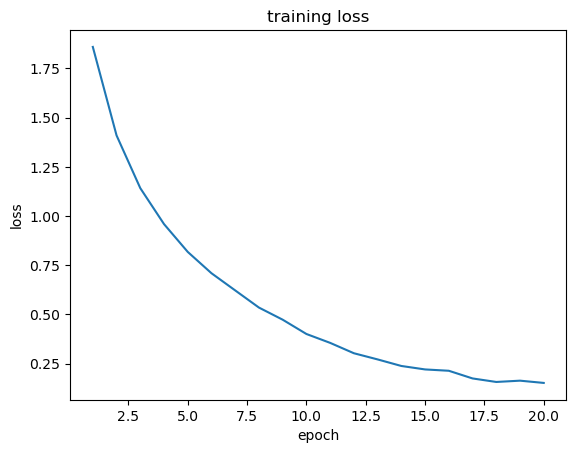

In [25]:
import matplotlib.pyplot as plt

x_index=range(1,21)

plt.plot(x_index, learning_curve, label='Train loss')
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

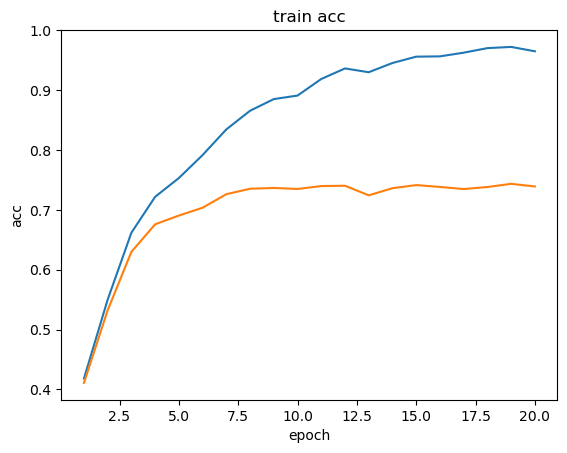

In [26]:
plt.plot(x_index, train_accuracy_curve, label='train acc')
plt.plot(x_index, val_accuracy_curve, label='val acc')
plt.title('train acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

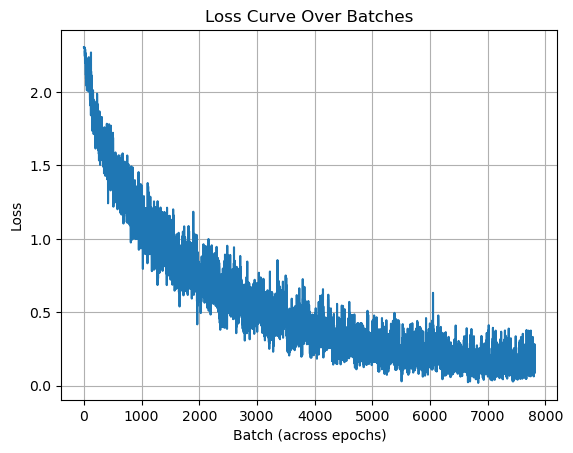

In [27]:
flattened_loss = [l for epoch in loss for l in epoch]

plt.plot(flattened_loss)
plt.title("Loss Curve Over Batches")
plt.xlabel("Batch (across epochs)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [28]:

loss_save_path = './loss_path'
grad_save_path = './grad_path'
train_loss_save_path = './train_loss_path'
train_acc_save_path = './train_acc_path'
val_acc_save_path = './val_acc_path'

os.makedirs(loss_save_path, exist_ok=True)
os.makedirs(grad_save_path, exist_ok=True)
os.makedirs(train_loss_save_path, exist_ok=True)
os.makedirs(train_acc_save_path, exist_ok=True)
os.makedirs(val_acc_save_path, exist_ok=True)

np.savetxt(os.path.join(loss_save_path, 'loss_vggdp.txt'), loss, fmt='%s', delimiter=' ')
# np.savetxt(os.path.join(grad_save_path, 'grads_vggA.txt'), grads, fmt='%s', delimiter=' ')
np.save(os.path.join(grad_save_path, "grads_vggdp.npy"), grads)
np.savetxt(os.path.join(train_loss_save_path, 'train_loss_vggdp.txt'), learning_curve, delimiter=' ')
np.savetxt(os.path.join(train_acc_save_path, 'train_acc_vggdp.txt'), train_accuracy_curve, delimiter=' ')
np.savetxt(os.path.join(val_acc_save_path, 'val_acc_vggdp.txt'), val_accuracy_curve, delimiter=' ')

可视化grad: